# 1. Nhập dữ liệu

In [1]:
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Descriptors, MACCSkeys
from rdkit.ML.Descriptors import MoleculeDescriptors

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Lấy luôn dữ liệu đã loc của tác giả
test_dataset = pd.read_csv("data_for_modeling/HDAC3_test.csv")
train_dataset = pd.read_csv("data_for_modeling/HDAC3_train.csv")

# 2. Xây dựng mô hình với Morgan2

## 2.1. Mã hóa cấu trúc phân tử

In [3]:
def morgan_fpts(data):
    Morgan_fpts = []
    for i in data:
        mol = Chem.MolFromSmiles(i)
        fpts = AllChem.GetMorganFingerprintAsBitVect(mol, 2, 1024)
        mfpts = np.array(fpts)
        Morgan_fpts.append(mfpts)
    return np.array(Morgan_fpts)

In [4]:
train_morgan_fpts = morgan_fpts(train_dataset['SMILES'])
test_morgan_fpts = morgan_fpts(test_dataset['SMILES'])

In [5]:
X_Train = train_morgan_fpts
X_Test = test_morgan_fpts
y_Train = np.array(train_dataset['Type'])
y_Test = np.array(test_dataset['Type'])

## 2.2. Xây dựng mô hình

__Random Forest Classifier__

In [6]:
from sklearn.ensemble import RandomForestClassifier
rf_morgan2 = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=0)
rf_morgan2.fit(X_Train, y_Train)

RandomForestClassifier(criterion='entropy', random_state=0)

__K Nearest Neighbor__

In [7]:
from sklearn.neighbors import KNeighborsClassifier
knn_morgan2 = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)
knn_morgan2.fit(X_Train, y_Train)

KNeighborsClassifier()

__SVM__

In [8]:
from sklearn.svm import SVC
svm_morgan2 = SVC(kernel='rbf', random_state=0)
svm_morgan2.fit(X_Train, y_Train)

SVC(random_state=0)

__XGBoost__

In [9]:
from xgboost import XGBClassifier
bst_morgan2 = XGBClassifier(n_estimators=100, objective='binary:logistic')
bst_morgan2.fit(X_Train, y_Train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

## 2.3. Đánh giá và so sánh mô hình của tác giả

### 2.3.1. 10-fold-cross validation

In [10]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [11]:
X_Total = np.concatenate((X_Train, X_Test), axis=0)
y_Total = np.concatenate((y_Train, y_Test), axis=0)

__RF__

In [12]:
cv = KFold(n_splits=10, random_state=1, shuffle=True)
scores = cross_val_score(rf_morgan2, X_Total, y_Total, scoring='accuracy', cv=cv, n_jobs=-1)
print('Độ chính xác của 10-fold cross validation: %.3f (%.3f)' % (scores.mean(), scores.std()))
print('So sánh với độ chính xác của bài báo là: ' + str(0.863))

Độ chính xác của 10-fold cross validation: 0.842 (0.037)
So sánh với độ chính xác của bài báo là: 0.863


__KNN__

In [13]:
cv = KFold(n_splits=10, random_state=1, shuffle=True)
scores = cross_val_score(knn_morgan2, X_Total, y_Total, scoring='accuracy', cv=cv, n_jobs=-1)
print('Độ chính xác của 10-fold cross validation: %.3f (%.3f)' % (scores.mean(), scores.std()))
print('So sánh với độ chính xác của bài báo là: ' + str(0.853))

Độ chính xác của 10-fold cross validation: 0.851 (0.027)
So sánh với độ chính xác của bài báo là: 0.853


__SVM__

In [14]:
cv = KFold(n_splits=10, random_state=1, shuffle=True)
scores = cross_val_score(svm_morgan2, X_Total, y_Total, scoring='accuracy', cv=cv, n_jobs=-1)
print('Độ chính xác của 10-fold cross validation: %.3f (%.3f)' % (scores.mean(), scores.std()))
print('So sánh với độ chính xác của bài báo là: ' + str(0.859))

Độ chính xác của 10-fold cross validation: 0.854 (0.025)
So sánh với độ chính xác của bài báo là: 0.859


__XGBoost__

In [15]:
cv = KFold(n_splits=10, random_state=1, shuffle=True)
scores = cross_val_score(bst_morgan2, X_Total, y_Total, scoring='accuracy', cv=cv, n_jobs=-1)
print('Độ chính xác của 10-fold cross validation: %.3f (%.3f)' % (scores.mean(), scores.std()))
print('So sánh với độ chính xác của bài báo là: ' + str(0.858))

Độ chính xác của 10-fold cross validation: 0.853 (0.032)
So sánh với độ chính xác của bài báo là: 0.858


### 2.3.2. Accuracy, Sensitivity, Specificity

In [16]:
from sklearn.metrics import confusion_matrix, accuracy_score
from tabulate import tabulate
import math

In [17]:
def model_evaluation_calculation(cm):
    tp = cm[0][0]; tn = cm[1][1]; fp = cm[0][1]; fn = cm[1][0]
    ac = (tp+tn)/(tp+tn+fp+fn)
    se = tp/(tp+fn)
    sp = tn/(tn+fp)
    mcc = (tp*tn - fp*fn) / math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    return ac, se, sp, mcc

In [18]:
def me_result(cm, ac1, se1, sp1, mcc1):
    print("Confusion matrix:")
    print(cm)
    ac, se, sp, mcc = model_evaluation_calculation(cm)
    print("Comparision:")
    table = [[' ' 'AC', 'SE', 'SP', 'MCC'], ['Shin Liu et at', ac1, se1, sp1, mcc1], ['My model', ac, se, sp, mcc]]
    print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

RF

In [19]:
#Random Forest
y_rf_pred = rf_morgan2.predict(X_Test)
cm = confusion_matrix(y_Test, y_rf_pred)
ac1, se1, sp1, mcc1 = 0.894, 0.964, 0.729, 0.739
me_result(cm, ac1, se1, sp1, mcc1)

Confusion matrix:
[[ 41  18]
 [  8 131]]
Comparision:
╒════════════════╤══════════╤══════════╤══════════╤══════════╕
│                │       AC │       SE │       SP │      MCC │
╞════════════════╪══════════╪══════════╪══════════╪══════════╡
│ Shin Liu et at │ 0.894    │ 0.964    │ 0.729    │ 0.739    │
├────────────────┼──────────┼──────────┼──────────┼──────────┤
│ My model       │ 0.868687 │ 0.836735 │ 0.879195 │ 0.675504 │
╘════════════════╧══════════╧══════════╧══════════╧══════════╛


KNN

In [20]:
#KNN
y_knn_pred = knn_morgan2.predict(X_Test)
cm = confusion_matrix(y_Test, y_knn_pred)
ac1, se1, sp1, mcc1 = 0.874, 0.935, 0.729, 0.690
me_result(cm, ac1, se1, sp1, mcc1)

Confusion matrix:
[[ 43  16]
 [  9 130]]
Comparision:
╒════════════════╤══════════╤══════════╤══════════╤══════════╕
│                │       AC │       SE │       SP │      MCC │
╞════════════════╪══════════╪══════════╪══════════╪══════════╡
│ Shin Liu et at │ 0.874    │ 0.935    │ 0.729    │ 0.69     │
├────────────────┼──────────┼──────────┼──────────┼──────────┤
│ My model       │ 0.873737 │ 0.826923 │ 0.890411 │ 0.690186 │
╘════════════════╧══════════╧══════════╧══════════╧══════════╛


SVM

In [21]:
#SVM
y_svm_pred = svm_morgan2.predict(X_Test)
cm = confusion_matrix(y_Test, y_svm_pred)
ac1, se1, sp1, mcc1 = 0.869, 0.935, 0.712, 0.677
me_result(cm, ac1, se1, sp1, mcc1)

Confusion matrix:
[[ 41  18]
 [  7 132]]
Comparision:
╒════════════════╤══════════╤══════════╤═══════╤══════════╕
│                │       AC │       SE │    SP │      MCC │
╞════════════════╪══════════╪══════════╪═══════╪══════════╡
│ Shin Liu et at │ 0.869    │ 0.935    │ 0.712 │ 0.677    │
├────────────────┼──────────┼──────────┼───────┼──────────┤
│ My model       │ 0.873737 │ 0.854167 │ 0.88  │ 0.687903 │
╘════════════════╧══════════╧══════════╧═══════╧══════════╛


XGBoost

In [22]:
y_bst_pred = bst_morgan2.predict(X_Test)
cm = confusion_matrix(y_Test, y_bst_pred)
ac1, se1, sp1, mcc1 = 0.864, 0.950, 0.661, 0.661
me_result(cm, ac1, se1, sp1, mcc1)

Confusion matrix:
[[ 39  20]
 [  9 130]]
Comparision:
╒════════════════╤══════════╤════════╤══════════╤══════════╕
│                │       AC │     SE │       SP │      MCC │
╞════════════════╪══════════╪════════╪══════════╪══════════╡
│ Shin Liu et at │ 0.864    │ 0.95   │ 0.661    │ 0.661    │
├────────────────┼──────────┼────────┼──────────┼──────────┤
│ My model       │ 0.853535 │ 0.8125 │ 0.866667 │ 0.636369 │
╘════════════════╧══════════╧════════╧══════════╧══════════╛


### 2.3.3. AUC

In [23]:
from sklearn.metrics import RocCurveDisplay

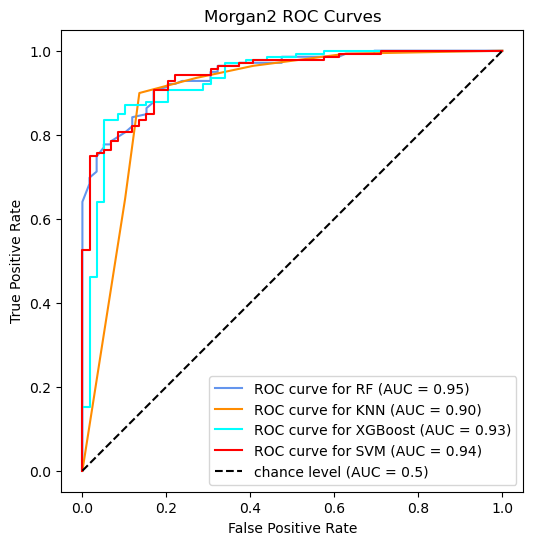

In [24]:
fig, ax = plt.subplots(figsize=(6, 6))

RocCurveDisplay.from_estimator(
    estimator=rf_morgan2, 
    X=X_Test, 
    y=y_Test,
    name=f"ROC curve for RF",
    color='cornflowerblue',
    ax=ax)


RocCurveDisplay.from_estimator(
    estimator=knn_morgan2, 
    X=X_Test, 
    y=y_Test,
    name=f"ROC curve for KNN",
    color='darkorange',
    ax=ax)

RocCurveDisplay.from_estimator(
    estimator=bst_morgan2, 
    X=X_Test, 
    y=y_Test,
    name=f"ROC curve for XGBoost",
    color='aqua',
    ax=ax)

RocCurveDisplay.from_estimator(
    estimator=svm_morgan2, 
    X=X_Test, 
    y=y_Test,
    name=f"ROC curve for SVM",
    color='red',
    ax=ax)

plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Morgan2 ROC Curves")
plt.legend()
plt.show()

# Cải thiện mô hình

In [25]:
neg_count, pos_count = 0, 0
for y_train_instance in y_Train:
    if y_train_instance == 0:
        neg_count = neg_count + 1
    else:
        pos_count = pos_count + 1

In [26]:
pos_count, neg_count

(533, 257)

In [27]:
#Remove the positive ones
y_Train_new = []
X_Train_new = []
max_pos_count = 12
max_neg_count = 257
cur_pos_count, cur_neg_count = 0, 0
for i in range(0, len(y_Train)):
    if (y_Train[i] == 1 and cur_pos_count < max_pos_count):
        y_Train_new.append(y_Train[i])
        X_Train_new.append(X_Train[i])
        cur_pos_count = cur_pos_count + 1
    elif(y_Train[i] == 0 and cur_neg_count < max_neg_count):
        y_Train_new.append(y_Train[i])
        X_Train_new.append(X_Train[i])
        cur_neg_count = cur_neg_count + 1
        
new_neg_count, new_pos_count = 0, 0
for y_train_instance in y_Train_new:
    if y_train_instance == 0:
        new_neg_count = new_neg_count + 1
    else:
        new_pos_count = new_pos_count + 1
print(new_neg_count, new_pos_count, len(y_Train_new), len(X_Train_new))

257 12 269 269


In [28]:
svm_morgan2_m1 = SVC(kernel='rbf')
svm_morgan2_m1.fit(X_Train_new, y_Train_new)

SVC()

In [29]:
#SVM
y_svm_pred = svm_morgan2_m1.predict(X_Test)
cm = confusion_matrix(y_Test, y_svm_pred)
ac1, se1, sp1, mcc1 = 0, 0, 0, 0
me_result(cm, ac1, se1, sp1, mcc1)

Confusion matrix:
[[ 59   0]
 [139   0]]
Comparision:
╒════════════════╤═════════╤═════════╤══════╤═══════╕
│                │      AC │      SE │   SP │   MCC │
╞════════════════╪═════════╪═════════╪══════╪═══════╡
│ Shin Liu et at │ 0       │ 0       │    0 │     0 │
├────────────────┼─────────┼─────────┼──────┼───────┤
│ My model       │ 0.29798 │ 0.29798 │  nan │   nan │
╘════════════════╧═════════╧═════════╧══════╧═══════╛


/tmp/ipykernel_36474/2263828191.py:5: RuntimeWarning: invalid value encountered in scalar divide
  sp = tn/(tn+fp)
/tmp/ipykernel_36474/2263828191.py:6: RuntimeWarning: invalid value encountered in divide
  mcc = (tp*tn - fp*fn) / math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


In [30]:
rf_morgan2_m1 = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=0)
rf_morgan2_m1.fit(X_Train_new, y_Train_new)

RandomForestClassifier(criterion='entropy', random_state=0)

In [31]:
y_pred = rf_morgan2_m1.predict(X_Test)
cm = confusion_matrix(y_Test, y_pred)
ac1, se1, sp1, mcc1 = 0, 0, 0, 0
me_result(cm, ac1, se1, sp1, mcc1)

Confusion matrix:
[[ 59   0]
 [136   3]]
Comparision:
╒════════════════╤══════════╤══════════╤══════╤═══════════╕
│                │       AC │       SE │   SP │       MCC │
╞════════════════╪══════════╪══════════╪══════╪═══════════╡
│ Shin Liu et at │ 0        │ 0        │    0 │ 0         │
├────────────────┼──────────┼──────────┼──────┼───────────┤
│ My model       │ 0.313131 │ 0.302564 │    1 │ 0.0808094 │
╘════════════════╧══════════╧══════════╧══════╧═══════════╛


Âm tính - Không âm tính - Dương tính và không dương tính

Gỉa thiết của thầy:
- Nếu biết được nhiều tính chất của âm tính thì ta sẽ dự đoán âm tính tốt hơn, do lượng âm tính lớn hơn dương tính rất nhiều nên ta sẽ dự đoán âm tính tốt hơn dự đoán dương tính, vì vậy thầy muốn ta xây dựng một mô hình dự đoán âm tính.
- Tuy nhiên khi để true-false = 1:10 thì mô hình lại dự đoán với tỷ lệ vô cùng tệ và có False Positive = 0, điều này lại ngược lại với giả thiết trên của thầy.
- Tìm hiểu lý do dẫn đến việc này!